# Group 24 Project Proposal
Jessica Liu, April Cao, Nathan Lee, An Zhou

## Introduction
This dataset is a user knowledge model created by a novel  “Intuitive Knowledge Classifier” method. This method takes the distances among the students’ optimum weight value of different features on their knowledge class and determines students’ knowledge class by dissimilarities in the process. (Kahraman, 2012) In this project, we are going to predict a numeric value of exam performance (PEG) using the degree of study time, the degree of repetition number of the user, the degree of study time of related objects of the user, and the related objects exam performance of the user (STG,SCG, STR, and LPR respectively). The dataset we are using is in the form of an excel sheet. It contains 5 numerical values (STG, SCG, STR, LPR and PEG) and one categorical value (UNS).

## Preliminary exploratory data analysis

In [1]:
#installing packages
# install.packages("tidymodels")
# install.packages("readxl")
# install.packages("repr")
# install.packages("tidyverse")
# install.packages("psych")
# install.packages("digest")
# install.packages("kknn")

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

also installing the dependency ‘igraph’




In [2]:
#libraries
library(psych)
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)
library(digest)
library(kknn)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::%+%()   masks psych::%+%()
✖ ggplot2::alpha() masks psych::alpha()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 0.2.0 ──

✔ broom        0.7.12     ✔ rsample      0.1.1 
✔ dials        0.1.1      ✔ tune         0.2.0 
✔ infer        1.0.0      ✔ workflows    0.2.6 
✔ modeldata    0.1.1      ✔ workflowsets 0.2.1 
✔ parsnip      0.2.1      ✔ yardstick    1.0.0 
✔ recipes      0.2.0      

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖

In [3]:
#loading in data
uk_data <- read_excel("data/user_knowledge_data.xls", sheet = 2)
uk_data <- uk_data %>%
    select(STG:UNS)
head(uk_data)

New names:
• `` -> `...7`
• `` -> `...8`


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


STG,SCG,STR,LPR,PEG,UNS,PEG_status
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low,q1
0.08,0.08,0.10,0.24,0.90,High,q4
0.06,0.06,0.05,0.25,0.33,Low,q2
0.10,0.10,0.15,0.65,0.30,Middle,q2
0.08,0.08,0.08,0.98,0.24,Low,q1
0.09,0.15,0.40,0.10,0.66,Middle,q3


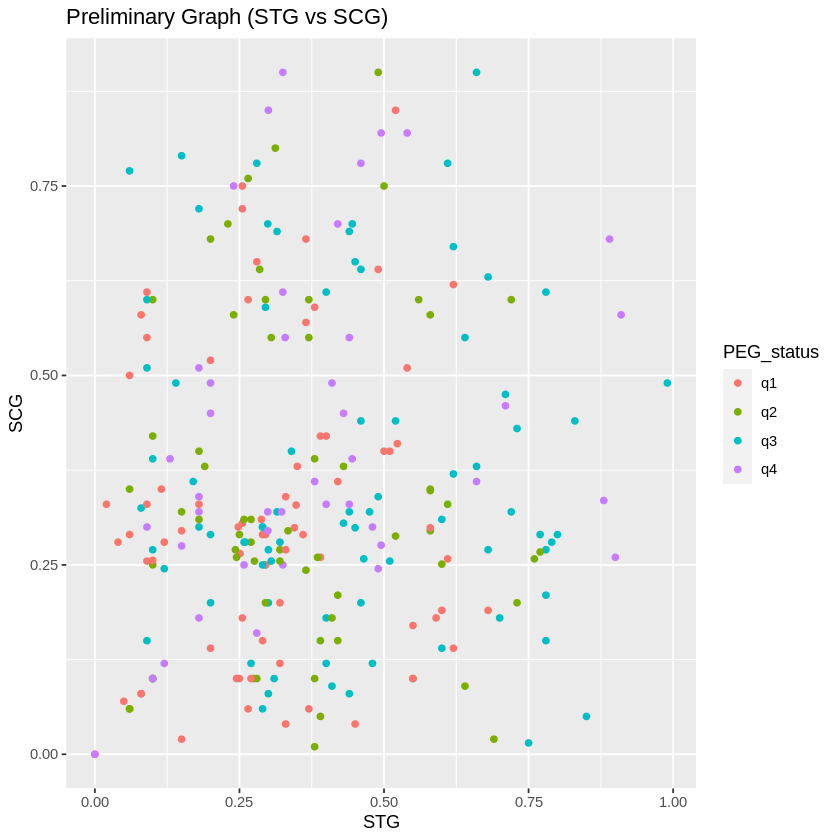

In [4]:
uk_data_new <- uk_data %>%
 mutate(PEG_status = case_when(PEG>=0 & PEG <= 0.25 ~ "q1",
                               PEG>0.25 & PEG <= 0.5 ~ "q2",
                               PEG>0.5 & PEG <= 0.75 ~ "q3",
                               PEG>0.75 & PEG <= 1 ~ "q4"))
head(uk_data_new)
stgscg_plot <- uk_data_new %>%
    ggplot(aes(x = STG, y = SCG, color = PEG_status)) +
    geom_point() +
    ggtitle("Preliminary Graph (STG vs SCG)")
stgscg_plot

|xxx|xxxx|

In [5]:
#splitting data
uk_split <- initial_split(uk_data, prop = 0.75, strata = PEG)  #strata is the column you're predicting
uk_train <- training(uk_split)   
uk_test <- testing(uk_split)

head(uk_train) #training set (75%)
head(uk_test) #testing set (25%)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.08,0.08,0.08,0.98,0.24,Low
0.15,0.02,0.34,0.40,0.01,very_low
0.20,0.14,0.35,0.72,0.25,Low
0.05,0.07,0.70,0.01,0.05,very_low
0.12,0.28,0.20,0.78,0.20,Low
0.04,0.28,0.55,0.25,0.10,very_low


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.10,0.10,0.15,0.65,0.30,Middle
0.10,0.10,0.43,0.29,0.56,Middle
0.00,0.00,0.50,0.20,0.85,High
0.18,0.18,0.55,0.30,0.81,High
0.12,0.12,0.75,0.35,0.80,High


In [6]:
#summary table
#via https://www.statology.org/summary-table-in-r/#:~:text=The%20easiest%20way%20to%20create%20summary%20tables%20in%20R%20is,functions%20from%20the%20psych%20library.
uk_train_summary <- describe(uk_train)
uk_train_summary

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
STG,1,192,0.3654427,0.2064721,0.3215,0.3494481,0.1905141,0.040,0.99,0.950,0.63699726,-0.09981453,0.01490084
SCG,2,192,0.3668646,0.2133088,0.3100,0.3537208,0.1853250,0.015,0.90,0.885,0.55093896,-0.51707069,0.01539424
STR,3,192,0.4684115,0.2484364,0.4700,0.4702273,0.2965200,0.020,0.95,0.930,-0.02420513,-1.11964785,0.01792935
LPR,4,192,0.4274479,0.2447720,0.3300,0.4152597,0.2298030,0.010,0.99,0.980,0.45064795,-0.97226027,0.01766490
PEG,5,192,0.4619948,0.2576481,0.5000,0.4588506,0.3261720,0.000,0.93,0.930,0.07942311,-1.25402435,0.01859415
UNS*,6,192,2.3020833,0.9447545,2.0000,2.2532468,1.4826000,1.000,4.00,3.000,0.07541807,-0.99747949,0.06818178


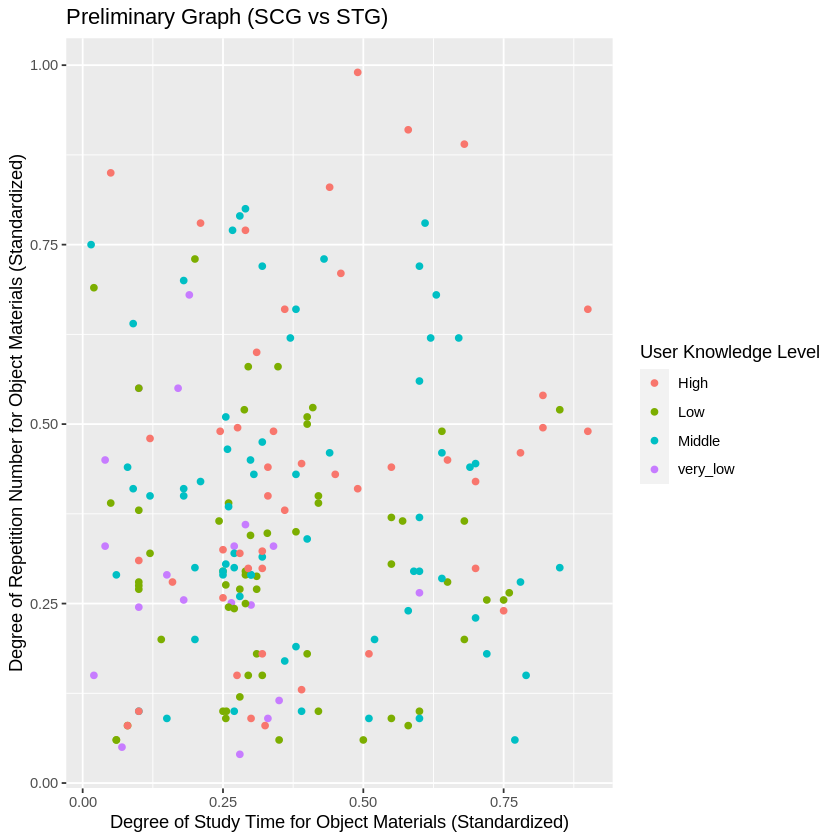

In [8]:
#plot (preliminary, does not have all the aspects we would like to use)
#q for TA: how to partition PEG into quarters so we can use colours to define each quarter percentile?
uk_train_plot <- uk_train %>%
    ggplot(aes(x = SCG, y = STG, colour = UNS)) +
    geom_point() +
    labs(x = "Degree of Study Time for Object Materials (Standardized)",
         y = "Degree of Repetition Number for Object Materials (Standardized)",
         colour = "User Knowledge Level") +
    ggtitle("Preliminary Graph (SCG vs STG)")
uk_train_plot

## Methods
After reading and tidying the data, we split it into 75% training data and 25% testing data to make better predictors and accurate predictions. We will start with a regression analysis to predict exam performance (PEG) using the study time (STG) and the repetition number (SCG) as predictors.  Using the training data, we are going to tune the model first to find the optimal K and avoid underfitting/overfitting issues. A scatter plot with STG on the x-axis, SCG on the y-axis, and PEG as colour/shape will be created to visualize the relationship. Since PEG is classified as a double (dbl), we will have to partition the PEG values into quarters (e,g, 0-0.25) to be able to assign the column as a colour. 

Next, STG, SCG, STR, and LPR will be used as predictors for exam performance. This will answer the question, “do students who spend more time studying, use a high degree of repetition, and have a stronger understanding of related materials score higher on their goal objects exam?

In [65]:
# create model specification
uk_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
       set_engine("kknn") %>%
       set_mode("regression") 
uk_spec

# create the recipe
uk_recipe <- recipe(PEG ~ STG + SCG + STR + LPR, data = uk_train) %>%
       step_scale(all_predictors()) %>%
       step_center(all_predictors())
uk_recipe

K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [66]:
# cross-validation
uk_vfold <- vfold_cv(uk_train, v = 5, strata = PEG)

gridvals <- tibble(neighbors = seq(1, 80))
head(gridvals)

uk_workflow <- workflow() %>%
    add_recipe(uk_recipe) %>%
    add_model(uk_spec)%>%
    tune_grid(resamples = uk_vfold, grid = gridvals) %>%
    collect_metrics()

head(uk_workflow)

neighbors
<int>
1
2
3
4
5
6


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,0.344570745,5,0.007275805,Preprocessor1_Model01
1,rsq,standard,0.009687164,5,0.003250686,Preprocessor1_Model01
2,rmse,standard,0.296329461,5,0.005910724,Preprocessor1_Model02
2,rsq,standard,0.030406917,5,0.008929199,Preprocessor1_Model02
3,rmse,standard,0.265679596,5,0.006836395,Preprocessor1_Model03
3,rsq,standard,0.075454044,5,0.016613223,Preprocessor1_Model03


In [67]:
# find k parameter with smallest rmse
uk_min <- uk_workflow %>%
    filter(.metric == "rmse") %>%
    arrange(mean) %>% 
    slice(1) %>%
    pull(neighbors)

uk_min

uk_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = uk_min) %>%
          set_engine("kknn") %>%
          set_mode("regression")

uk_best_fit <- workflow() %>%
          add_recipe(uk_recipe) %>%
          add_model(uk_best_spec) %>%
          fit(data = uk_train)

uk_summary <- uk_best_fit %>%
           predict(uk_test) %>%
           bind_cols(uk_test) %>%
           metrics(truth = PEG, estimate = .pred)
uk_summary

[1] 29

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.2274104
rsq,standard,0.1834094
mae,standard,0.1863265


In [68]:
# predictions
new_obv_1 <- tibble(STG = 0.89, SCG = 0.78, STR = 0.91, LPR = 0.12)
new_obv_pre_1 <- uk_best_fit %>%
           predict(new_obv)
new_obv_pre_1 #expected to be high, but actually kinda of low, but above average


new_obv_2 <- tibble(STG = 0.19, SCG = 0.04, STR = 0.21, LPR = 0.89)
new_obv_pre_2 <- uk_best_fit %>%
           predict(new_obv_2)
new_obv_pre_2 #as expected, is lower than average
 

new_obv_3 <- tibble(STG = 0.43, SCG = 0.41, STR = 0.47, LPR = 0.50)
new_obv_pre_3 <- uk_best_fit %>%
           predict(new_obv_3)
new_obv_pre_3 #lower than expected, thought it would be average

.pred
<dbl>
0.5425172


.pred
<dbl>
0.2724138


.pred
<dbl>
0.3882759


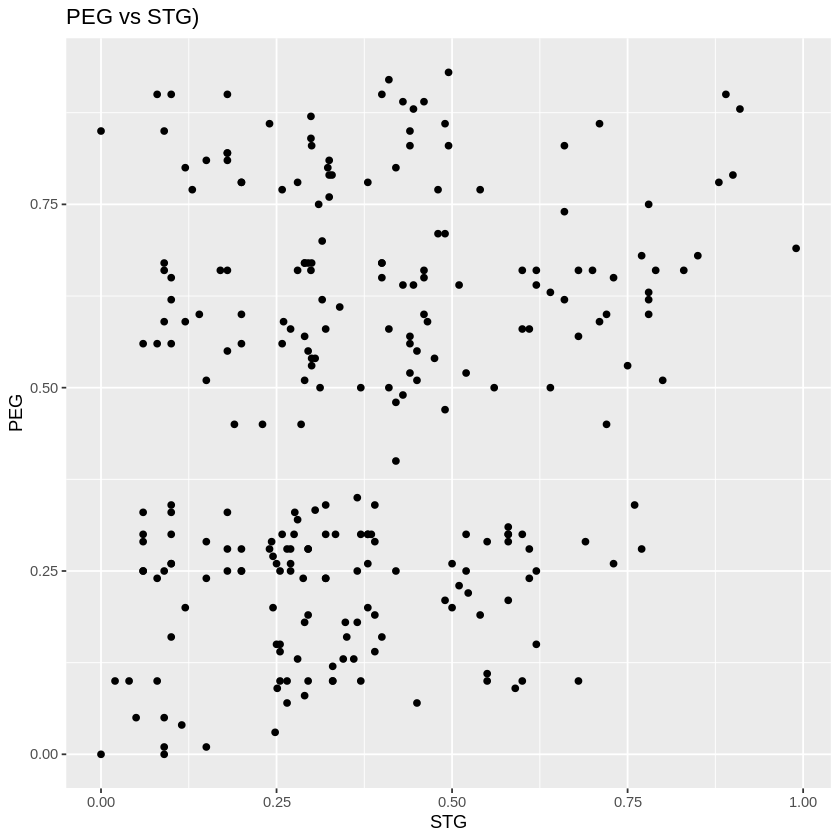

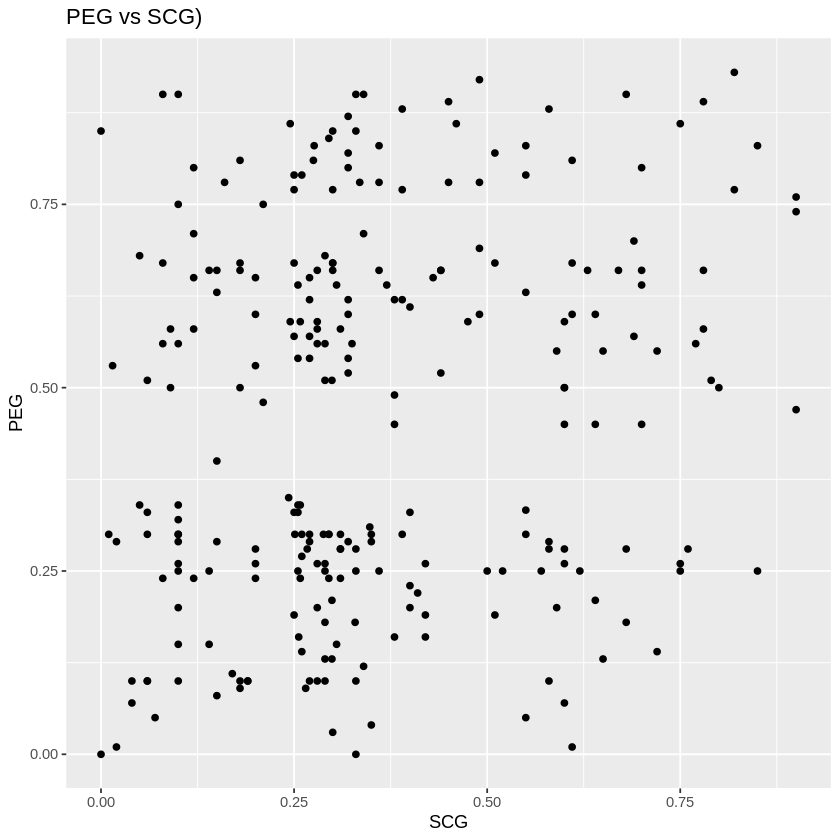

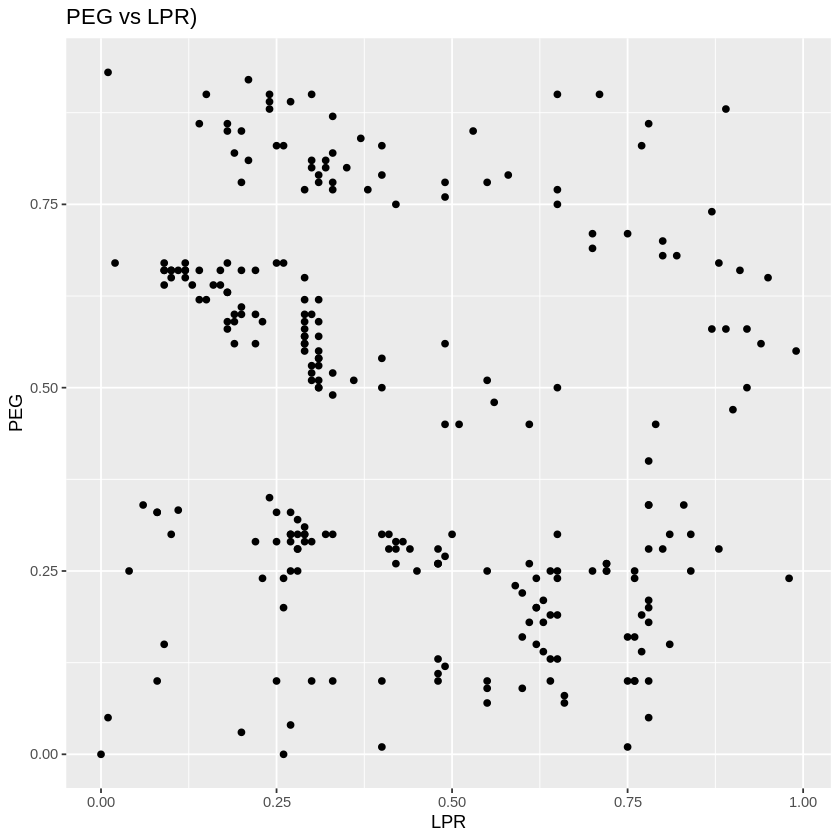

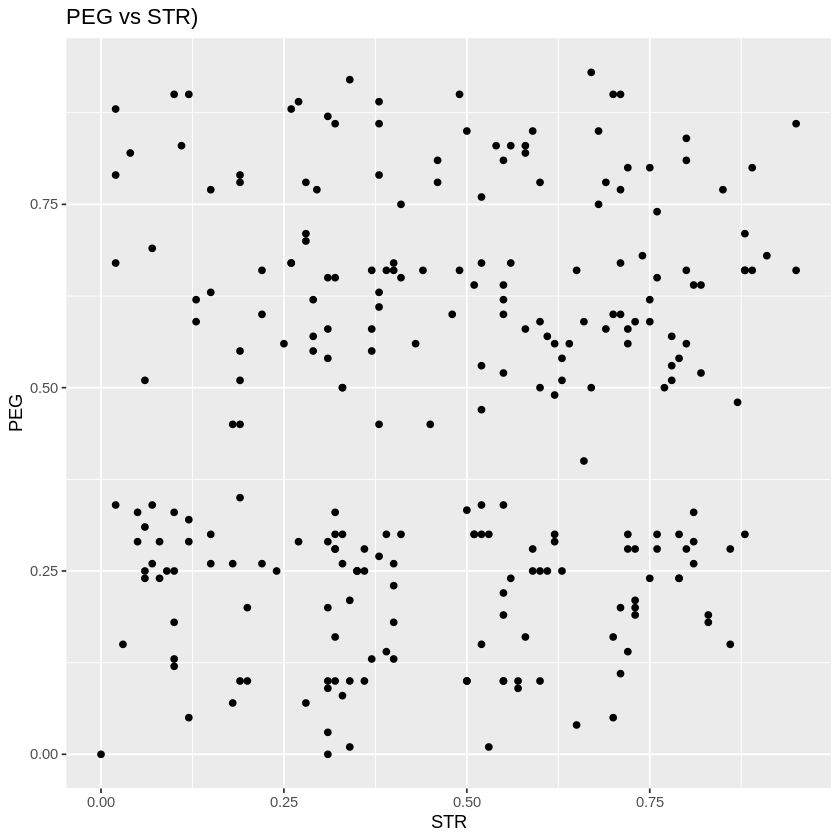

In [9]:
# plots (response variable vs. predictor)
stgpeg_plot <- uk_data_new %>%
    ggplot(aes(x = STG, y = PEG)) +
    geom_point() +
    ggtitle("PEG vs STG)")
stgpeg_plot

scgpeg_plot <- uk_data_new %>%
    ggplot(aes(x = SCG, y = PEG)) +
    geom_point()+
    ggtitle("PEG vs SCG (fig)")
scgpeg_plot

lprpeg_plot <- uk_data_new %>%
    ggplot(aes(x = LPR, y = PEG)) +
    geom_point()+
    ggtitle("PEG vs LPR (figure 4)")
lprpeg_plot

strpeg_plot <- uk_data_new %>%
    ggplot(aes(x = STR, y = PEG)) +
    geom_point()+
    ggtitle("PEG vs STR (figure 5)")
strpeg_plot

## Expected outcomes and significance
We expect to find a negative linear relationship between PEG and LPR, and a positive linear relationship between PEG and the three predictor variables STG, SCG, and STR respectively. As students spend more time studying the goal object materials, related material, or having repetitive exposure to the goal object material, they will perform better on the exam. However, they may not perform well on both exam simultaneously. Therefore, if the exam performance of user for the related objects is high, then the user may not perform as well on exam of goal objects, and vise versa.

This finding will give students an intuitive understanding that exam performance is correlated closely related to study time and the use of study materials. It can help students create a more time effective study plan that works for them. As a result, students may study more effectively and efficiently and achieve ideal exam performance.

Future questions:
1. Should students spend more time studying or reviewing material repeatedly in order to improve exam performance?
2. Is there research that shows a correlation between the combination of the most effective study schedules and methods of studying?

## Citations
Kahraman, H. T., Sagiroglu, S., &amp; Colak, I. (2012, August 21). The development of intuitive knowledge classifier and the modeling of Domain Dependent Data. Knowledge-Based Systems. Retrieved June 11, 2022, from https://www.sciencedirect.com/science/article/abs/pii/S0950705112002225 

In [62]:
# set.seed(2022) 

uk_split <- initial_split(uk_data, prop = 0.75, strata = PEG)  #strata is the column you're predicting
uk_train <- training(uk_split)   
uk_test <- testing(uk_split)

uk_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
       set_engine("kknn") %>%
       set_mode("regression") 
uk_spec
# create the recipe
uk_recipe <- recipe(PEG ~ STG + SCG + STR + LPR, data = uk_train) %>%
       step_scale(all_predictors()) %>%
       step_center(all_predictors())
uk_recipe

# cross-validation
uk_vfold <- vfold_cv(uk_train, v = 5, strata = PEG)

gridvals <- tibble(neighbors = seq(1, 80))
head(gridvals)

uk_workflow <- workflow() %>%
    add_recipe(uk_recipe) %>%
    add_model(uk_spec)%>%
    tune_grid(resamples = uk_vfold, grid = gridvals) %>%
    collect_metrics()

head(uk_workflow)

# find k with smallest rmse
uk_min <- uk_workflow %>%
    filter(.metric == "rmse") %>%
    arrange(mean) %>% 
    slice(1) %>%
    pull(neighbors)

uk_min



uk_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = uk_min) %>%
          set_engine("kknn") %>%
          set_mode("regression")

uk_best_fit <- workflow() %>%
          add_recipe(uk_recipe) %>%
          add_model(uk_best_spec) %>%
          fit(data = uk_train)

uk_summary <- uk_best_fit %>%
           predict(uk_test) %>%
           bind_cols(uk_test) %>%
           metrics(truth = PEG, estimate = .pred)
uk_summary

K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Centering for all_predictors()

neighbors
<int>
1
2
3
4
5
6


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,0.35083174,5,0.013460771,Preprocessor1_Model01
1,rsq,standard,0.01472898,5,0.005336598,Preprocessor1_Model01
2,rmse,standard,0.31397188,5,0.012686369,Preprocessor1_Model02
2,rsq,standard,0.01609076,5,0.005001624,Preprocessor1_Model02
3,rmse,standard,0.27824121,5,0.008062187,Preprocessor1_Model03
3,rsq,standard,0.04602093,5,0.022212987,Preprocessor1_Model03


[1] 20

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.2290526
rsq,standard,0.1647814
mae,standard,0.1807894


In [64]:
new_obv <- tibble(STG = 0.89, SCG = 0.78, STR = 0.91, LPR = 0.12)
new_obv_pre <- uk_best_fit %>%
           predict(new_obv)
new_obv_pre #expected to be high, but actually kinda of low, but above average


new_obv_2 <- tibble(STG = 0.19, SCG = 0.04, STR = 0.21, LPR = 0.89)
new_obv_pre_2 <- uk_best_fit %>%
           predict(new_obv_2)
new_obv_pre_2 #as expected, is lower than average
 

new_obv_3 <- tibble(STG = 0.43, SCG = 0.41, STR = 0.47, LPR = 0.50)
new_obv_pre_3 <- uk_best_fit %>%
           predict(new_obv_3)
new_obv_pre_3 #lower than expected, thought it would be average

.pred
<dbl>
0.582


.pred
<dbl>
0.2585


.pred
<dbl>
0.3535


STG,SCG,STR,LPR,PEG,UNS,PEG_status
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.000,0.000,0.00,0.00,0.00,very_low,q1
0.080,0.080,0.08,0.98,0.24,Low,q1
0.150,0.020,0.34,0.40,0.01,very_low,q1
0.200,0.140,0.35,0.72,0.25,Low,q1
0.050,0.070,0.70,0.01,0.05,very_low,q1
0.120,0.280,0.20,0.78,0.20,Low,q1
0.060,0.290,0.35,0.76,0.25,Low,q1
0.040,0.280,0.55,0.25,0.10,very_low,q1
0.090,0.255,0.60,0.45,0.25,Low,q1


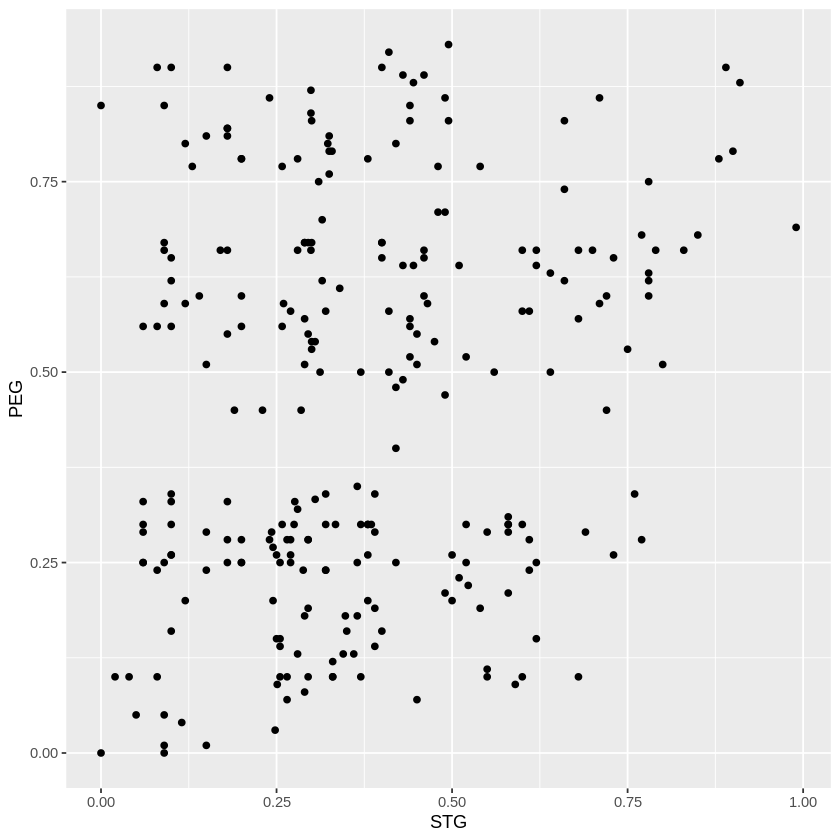

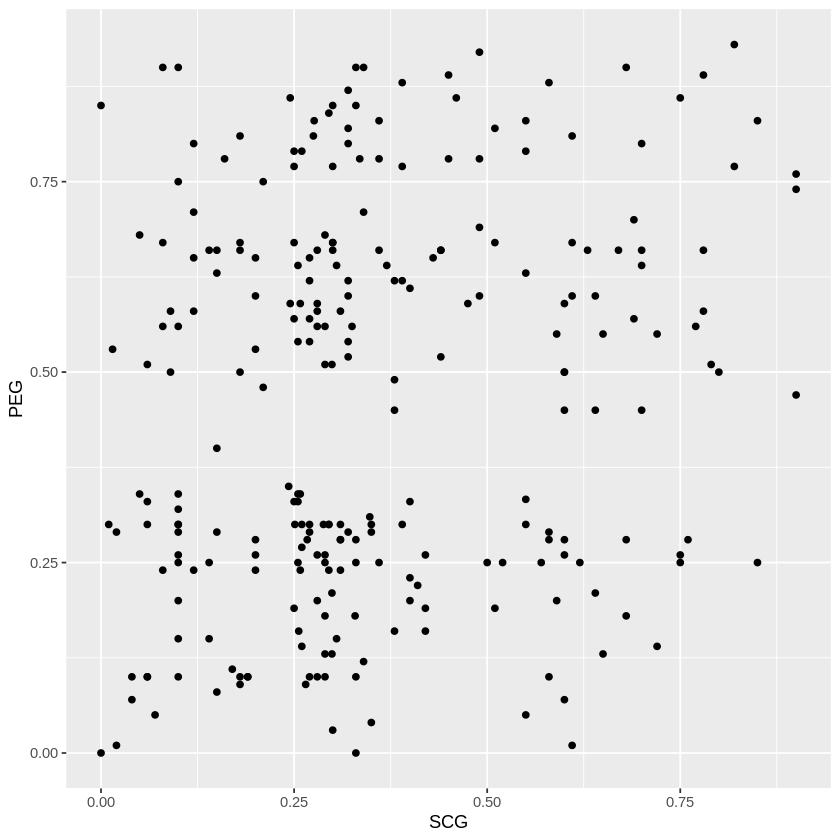

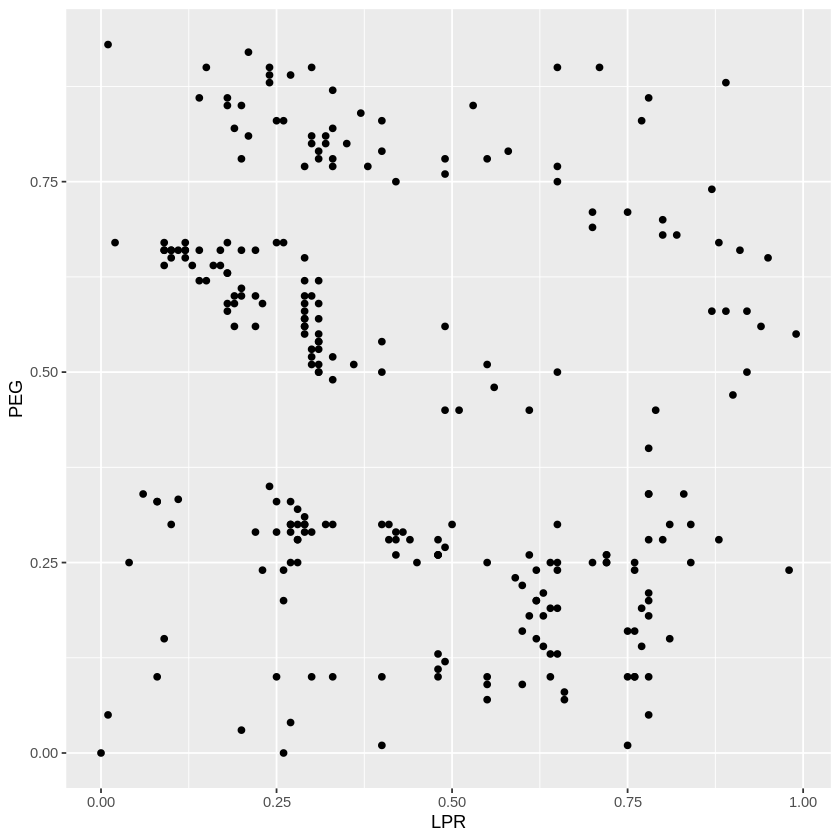

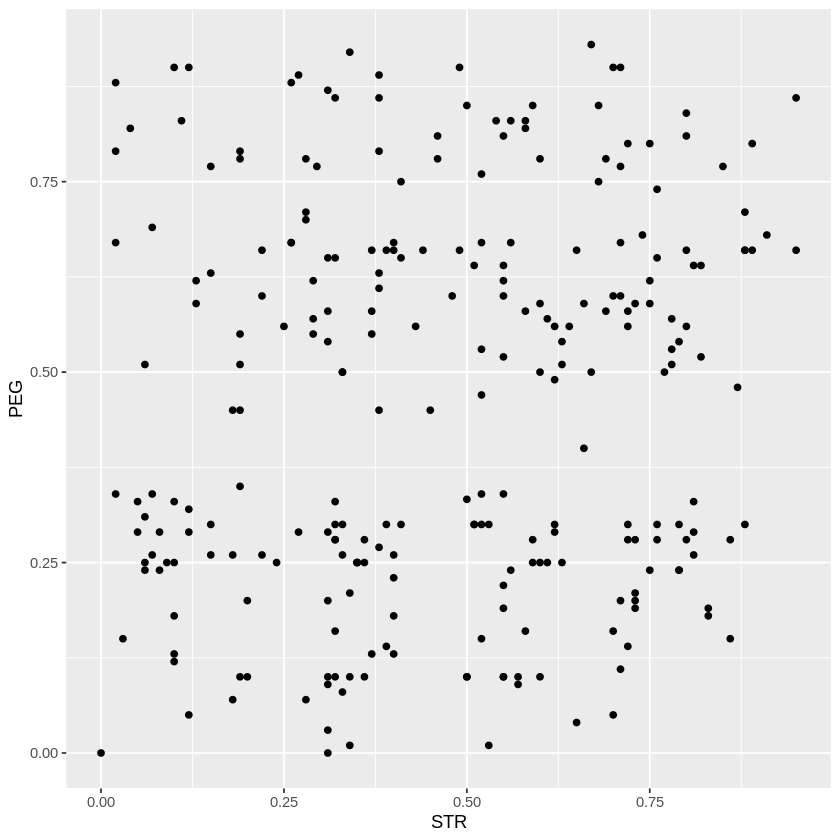

In [56]:
uk_data_peg_filter <- uk_data_new %>%
    filter(PEG_status == "q1")
uk_data_peg_filter

stgpeg_plot <- uk_data_new %>%
    ggplot(aes(x = STG, y = PEG)) +
    geom_point()
stgpeg_plot

scgpeg_plot <- uk_data_new %>%
    ggplot(aes(x = SCG, y = PEG)) +
    geom_point()
scgpeg_plot

lprpeg_plot <- uk_data_new %>%
    ggplot(aes(x = LPR, y = PEG)) +
    geom_point()
lprpeg_plot

strpeg_plot <- uk_data_new %>%
    ggplot(aes(x = STR, y = PEG)) +
    geom_point()
strpeg_plot

In [17]:
nrow(uk_train)
nrow(uk_test)

[1] 192

[1] 66

STG,SCG,STR,LPR,PEG,UNS,PEG_status
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.080,0.080,0.100,0.24,0.90,High,q4
0.000,0.000,0.500,0.20,0.85,High,q4
0.180,0.180,0.550,0.30,0.81,High,q4
0.100,0.100,0.700,0.15,0.90,High,q4
0.120,0.120,0.750,0.35,0.80,High,q4
0.090,0.300,0.680,0.18,0.85,High,q4
0.150,0.275,0.800,0.21,0.81,High,q4
0.180,0.320,0.040,0.19,0.82,High,q4
0.200,0.450,0.280,0.31,0.78,High,q4


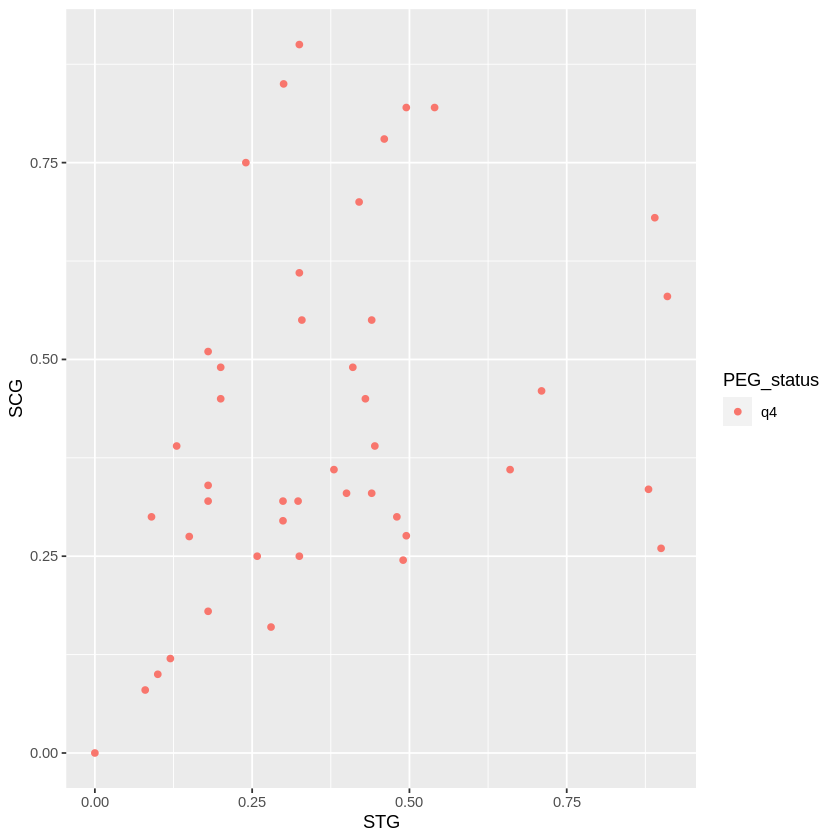

In [33]:
uk_data_peg_filter <- uk_data_new %>%
    filter(PEG_status == "q4")
uk_data_peg_filter

stgscg_plotf <- uk_data_peg_filter %>% #not that good
    ggplot(aes(x = STG, y = SCG, color = PEG_status)) +
    geom_point()
stgscg_plotf